In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
def gc_to_pft():
    ''' can be used to xfer gc data to pft 
        via da.stack({'gc':['lat','lon']}).isel(gc=ix)
        '''
    d='/glade/derecho/scratch/slevis/archive/ctsm53017_f19_BNF_hist/lnd/hist/'
    files=sorted(glob.glob(d+'*h1*'))
    tmp=xr.open_dataset(files[0])
    nlon=len(tmp.lon)
    nlat=len(tmp.lat)
    ix=((tmp.pfts1d_jxy-1)*nlon+tmp.pfts1d_ixy-1).astype(int)
    return ix

In [3]:
def fix_time(ds):
    yr0=str(ds['time.year'][0].values)
    nt=len(ds.time)
    ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    return ds

### creating the lapxb file for sparsegrid data

In [10]:
d='/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_lhc0000/run/'
sgfiles=sorted(glob.glob(d+'*h1*'))
sg=xr.open_dataset(sgfiles[0])

In [25]:
#loading files
wfile='/glade/u/home/djk2120/ctsm6_ppe/biomes/whit/whitkey.nc'
whit=xr.open_dataset(wfile)
cfile='/glade/u/home/djk2120/ctsm6_ppe/sparsegrid/pftmean/ctsm53017_f19_BNF_sgpft_cribsheet.nc'
crib=xr.open_dataset(cfile)
afile='/glade/u/home/djk2120/ctsm6_ppe/sparsegrid/pftmean/lapft_ctsm53017.nc'
lapft=xr.open_dataset(afile).lapft

In [40]:
#labeling all the patches by pxb
ix=gc_to_pft()
p=crib.pfts1d_itype_veg
pu=xr.DataArray(np.unique(p),dims='vegtype')
b=whit.biome_fg.stack({'gc':['lat','lon']}).isel(gc=ix)
bu=xr.DataArray(np.unique(b),dims='biome')
pxbmap=(b==bu)&(p==pu)

In [41]:
#accumulating all the fg patches into sg cohorts
good=(crib.not_antarctica)
g=crib.sgpft_cribsheet
g.name='sgpft'
x=(pxbmap*lapft.where(good)).groupby(g).sum()

In [103]:
s=[len(x[d]) for d in x.dims]
s[0]=len(sg.pft)
dims=[d for d in x.dims]
dims[0]='pft'
xout=xr.DataArray(np.zeros(s),dims=dims)
xout[x.sgpft,:,:,:]=x
xout['year']=x.year

In [105]:
dsout=xr.Dataset()
dsout['lapxb_sg']=xout
dsout['pft_name']=pft_abbrevs()
dsout['biome_name']=xr.DataArray(whit.biome_name.values,dims='biome')
for v in ['itype_veg','lat','lon']:
    dsout['pfts1d_'+v]=sg['pfts1d_'+v]
dsout.attrs={'script':'/glade/u/home/djk2120/ctsm6_ppe/biomes/biome_area.ipynb',
             'biomes':wfile,
             'lapft':afile,
             'patch_similarity':cfile}
file='lapxb_sg_whit_ctsm53017.nc'
dsout.to_netcdf(file)

### repeating for sudoku

In [133]:
#loading files
wfile='/glade/u/home/linnia/ctsm6_ppe/biomes/sudoku_biomes.nc'
sud=xr.open_dataset(wfile)

In [134]:
#labeling all the patches by pxb
ix=gc_to_pft()
p=crib.pfts1d_itype_veg
pu=xr.DataArray(np.unique(p),dims='vegtype')
b=sud.sudoku_biomes.stack({'gc':['lat','lon']}).isel(gc=ix)
bu=xr.DataArray(np.unique(b),dims='biome')
pxbmap=(b==bu)&(p==pu)

In [142]:
#accumulating all the fg patches into sg cohorts
good=(crib.not_antarctica)
g=crib.sgpft_cribsheet
g.name='sgpft'
x=(pxbmap*lapft.where(good)).groupby(g).sum()

### test usage

In [106]:
#loading files
tmp=xr.open_dataset('lapxb_sg_whit_ctsm53017.nc')
lapxb=tmp.lapxb_sg
d='/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_lhc0000/run/'
sgfiles=sorted(glob.glob(d+'*.h1.*'))
sg=fix_time(xr.open_dataset(sgfiles[-2]))

In [107]:
lai=sg.TLAI.groupby('time.year').mean()


In [108]:
lapxb=tmp.lapxb_sg


In [127]:
### biome average LAI, via h1 data
x=(lapxb*lai).sum(dim=['pft','vegtype'])/(lapxb).sum(dim=['pft','vegtype'])
xm=x.mean(dim='year')

<BarContainer object of 10 artists>

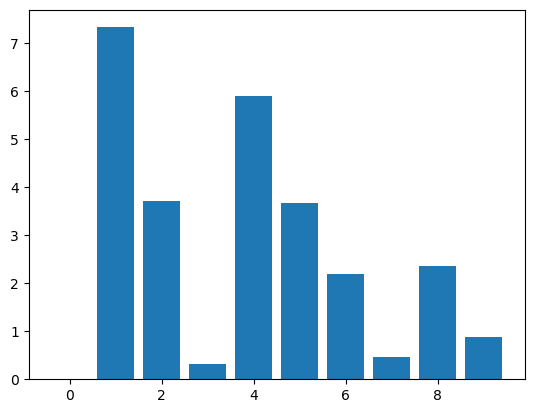

In [129]:
plt.bar(range(10),xm)

In [114]:
x=((lai*lapxb).sum(dim='pft')/lapxb.sum(dim='pft')).mean(dim='year')

In [119]:
x.isel(vegtype=1)

<xarray.DataArray (biome: 10)>
array([        nan, 10.30289504,  8.30604246,  5.86964645,  6.09364138,
        6.9468605 ,  6.83459372,  5.14620941,  5.87390705,  4.4533267 ])
Dimensions without coordinates: biome

In [426]:
npxb=len(lapxb.pxb)

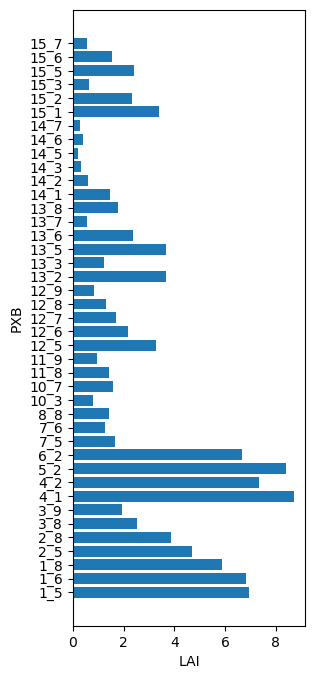

In [435]:
plt.figure(figsize=[3,8])
plt.barh(range(npxb),laipxb.mean(dim='year'))
plt.yticks(range(npxb),lapxb.pxb.values)
plt.ylabel('PXB')
plt.xlabel('LAI');

### processing SP data

In [534]:
#load the SP data
d='/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_SP_0/run/'
f=glob.glob(d+'*.h1.*')[0]
ds=fix_time(xr.open_dataset(f))

In [497]:
#make the lapxb matrix
ix=gc_to_pft()
la=ds.area*ds.landfrac
lapft=la.stack({'gc':['lat','lon']}).isel(gc=ix)*ds.pfts1d_wtgcell
lapxb=(lapft.where(good)*pxbmap).stack({'pxb':['vegtype','biome']}).isel(pxb=ixbig)
lapxb=lapxb.drop_vars(['gc','pxb', 'vegtype', 'biome'])
lapxb['pxb']=np.array(pxb)[ixbig]

In [541]:
#calculate LAI_pxb
dpm=ds['time.daysinmonth']
lai=ds.TLAI.weighted(dpm).mean(dim='time')
laipxb_sp=(lai*lapxb).sum(dim='pft')/lapxb.sum(dim='pft')
laipxb_sp.attrs=ds.TLAI.attrs

In [582]:
#annotate and write to disk
dsout=xr.Dataset()
dsout['lapxb_sp']=lapxb
dsout['p']=tmp.p
dsout['TLAI_SP']=laipxb_sp
dsout.attrs={'script':'/glade/u/home/djk2120/ctsm6_ppe/biomes/biome_area.ipynb',
             'biomes':wfile}
dsout.to_netcdf('TLAI_SP_pxb_whit_ctsm53017.nc')

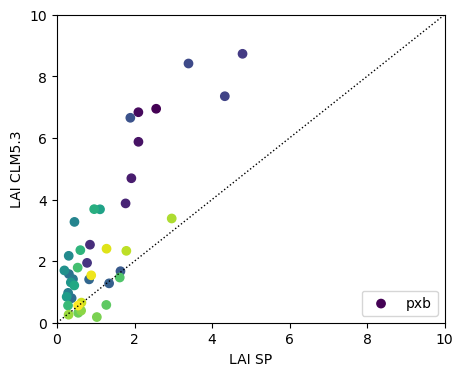

In [575]:
npxb=len(laipxb.pxb)
plt.figure(figsize=[5,4])
plt.scatter(laipxb_sp,laipxb.mean(dim='year'),c=range(npxb),label='pxb')
plt.xlim([0,10])
plt.ylim([0,10])
plt.plot([0,10],[0,10],'k:',lw=1)
plt.xlabel('LAI SP')
plt.ylabel('LAI CLM5.3')
plt.legend(loc=4);

### older stuff

In [55]:
#nixing small pxbs and copying to a correctly shaped array
atol=4e5 #size of paraguay
xsta=x.stack({'pxb':['vegtype','biome']})
ixbig=xsta.sel(year=slice(2000,2020)).mean(dim='year').sum(dim='sgpft')>atol
npxb=ixbig.sum().values
s=(len(sg.pft),len(xsta.year),npxb)
xout=xr.DataArray(np.zeros(s),dims=['pft','year','pxb'])
xout[x.sgpft,:,:]=xsta.isel(pxb=ixbig)

<xarray.DataArray (vegtype: 17)>
array(['BG', 'NEMT', 'NEBT', 'NDBT', 'BETT', 'BEMT', 'BDTT', 'BDMT',
       'BDBT', 'BES', 'BDMS', 'BDBS', 'C3AG', 'C3G', 'C4G', 'C3C', 'C3I'],
      dtype='<U4')
Dimensions without coordinates: vegtype

In [633]:
f1='lapxb_sg_whit_ctsm53017.nc'
f2='TLAI_SP_pxb_whit_ctsm53017.nc'
for f in [f1,f2]:
    ds=xr.open_dataset(f.replace('.nc','.old'))
    ds['pft_name']=pft
    ds['biome_name']=whit.biome_name
    ds.to_netcdf(f)

In [632]:
ds

<xarray.Dataset>
Dimensions:     (pxb: 41, year: 104, pft: 8454, pft_id: 17, biome_id: 10)
Coordinates:
    p           (pxb) int64 ...
    b           (pxb) int64 ...
  * pxb         (pxb) <U4 '1_5' '1_6' '1_8' '2_5' ... '15_5' '15_6' '15_7'
  * year        (year) int64 1920 1921 1922 1923 1924 ... 2020 2021 2022 2023
Dimensions without coordinates: pft, pft_id, biome_id
Data variables:
    lapxb_sg    (pft, year, pxb) float64 ...
    pft_name    (pft_id) <U4 'BG' 'NEMT' 'NEBT' 'NDBT' ... 'C4G' 'C3C' 'C3I'
    biome_name  (biome_id) <U32 ...
Attributes:
    script:            /glade/u/home/djk2120/ctsm6_ppe/biomes/biome_area.ipynb
    biomes:            /glade/u/home/djk2120/ctsm6_ppe/biomes/whit/whitkey.nc
    lapft:             /glade/u/home/djk2120/ctsm6_ppe/sparsegrid/pftmean/lap...
    patch_similarity:  /glade/u/home/djk2120/ctsm6_ppe/sparsegrid/pftmean/cts...

In [622]:
pft.name='pft_name'

In [626]:
f1='lapxb_sg_whit_ctsm53017.old'
f2='TLAI_SP_pxb_whit_ctsm53017.old'

pft.to_netcdf(f1,'a')
#pft.to_netcdf(f2,'a')
whit.biome_name.to_netcdf(f1,'a')
#whit.biome_name.to_netcdf(f2,'a')

OSError: [Errno -101] NetCDF: HDF error: '/glade/u/home/djk2120/ctsm6_ppe/biomes/lapxb_sg_whit_ctsm53017.old'

### calculate and save transient pft area

In [40]:
def pp(ds):
    return ds['pfts1d_wtgcell']
wtg=xr.open_mfdataset(files[::12],combine='nested',concat_dim='year',preprocess=pp)
wtg['year']=range(1920,2024)

In [66]:
d='/glade/derecho/scratch/slevis/archive/ctsm53017_f19_BNF_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h1*'))
tmp=xr.open_dataset(files[0])
nlon=len(tmp.lon)
nlat=len(tmp.lat)
ix=((tmp.pfts1d_jxy-1)*nlon+tmp.pfts1d_ixy-1).astype(int)
a=tmp.area*tmp.landfrac
apft=(a.stack({'gc':['lat','lon']}).isel(gc=ix)*wtg).compute()

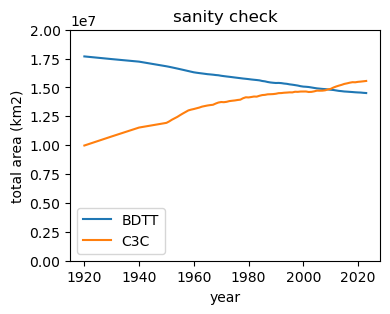

In [68]:
g=tmp.pfts1d_itype_veg
g.name='vegtype'
x=apft.groupby(g).sum().compute()

plt.figure(figsize=[4,3])
x.isel(vegtype=4).plot()
x.isel(vegtype=15).plot()

plt.legend(['BDTT','C3C'])
plt.ylim([0,2e7])
plt.ylabel('total area (km2)')
plt.title('sanity check');

In [77]:
#append to file
f='../sparsegrid/pftmean/lapft_ctsm53017.nc'
dsout=xr.Dataset()
dsout['lapft']=apft
s='/glade/u/home/djk2120/ctsm6_ppe/biomes/biome_area.ipynb'
dsout.attrs={'case':d,'script':s}
dsout.drop('gc').to_netcdf(f)

### looking at gpp across the 10 biomes

In [5]:
d='/glade/derecho/scratch/slevis/archive/ctsm53017_f19_BNF_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h0*'))
tmp=xr.open_dataset(files[0])
la=tmp.area*tmp.landfrac
climo=xr.open_dataset('crujra_climo.nc')
gpp=climo.GPP*24*60*60*365*1e-9*la

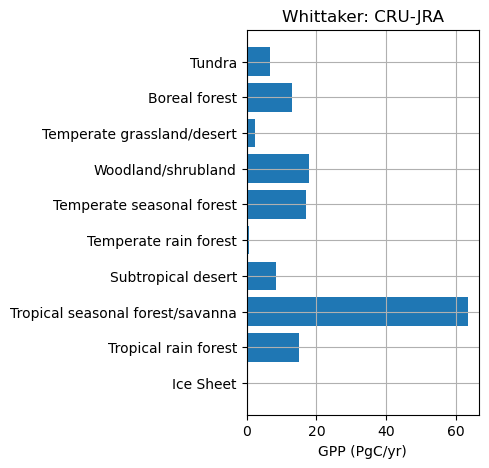

In [27]:
plt.figure(figsize=[3,5])
plt.barh(range(10),gpp.groupby(whit.biome_fg).sum())
plt.yticks(range(10),whit.biome_name.values)
plt.grid()
plt.xlabel('GPP (PgC/yr)')
plt.title('Whittaker: CRU-JRA')
plt.savefig('whittaker_gpp.png',dpi=300,bbox_inches='tight');